In [202]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
import numpy as np

from tqdm.notebook import trange

from pathlib import Path
colour = Path('../GTA_images/Simple/Colour')
depth = Path('../GTA_images/Simple/Depth')

import sys
sys.path.append('../')

from depth_Functions import (
    import_raw_colour_image, 
    import_raw_depth_image, 
    show_img, 
    show_list_of_images
)

from Feature_Extraction import (
    create_feature_vector,
    process_patches
)

# Local Absolute Depth

## Equation

Our goal is to create parameters for the function:

$$d_i = \theta_r x_i$$

We do this using the Gaussian equation below:

$$P(d|X;\theta;\sigma_{1r}) = \frac{1}{Z}\exp{\left({-\sum_\limits{i=1}^{M}d_i-x_i^T\theta_r}\right)}$$

## Variables

| Variables |Description|
|-|-|
|$P(d|X)$|probable depth d given image features X|
|$\theta$|parameter calculated during training|
| Z | Normalisation constant |
| M | Number of patches |
|$d_i$|depth at a given patch|
|$x_i$|feature vector at patch|


## Training

### Equations

In training our goal is to determine $\theta$, this is done by maximising the value l(d):

 $$l(d) = \log{P(d|X;\theta_r)}$$


 $$l(d) = \log\left(\frac{1}{Z}\right)\left({-\sum_\limits{i=1}^{M}d_i-\theta_r x_i^T}\right)$$

Linear least squares is used to determine the value of $\theta$ that will maximise l(d), which occurs as:

$$\left({\sum_\limits{i=1}^{M}d_i-x_i^T\theta_r}\right) \rightarrow 0$$

$\therefore$ we can find the least square of the equation:

$$d_i = \theta_rx_i^T$$

In [148]:
np.array([[1,2], [1,2]]).flatten()

array([1, 2, 1, 2])

In [297]:
from scipy import optimize

def function(x, *𝜃):
    return x @ np.array(𝜃)

def least_squares(features, depth, 𝜃):
    return optimize.curve_fit(function, 
                              xdata=features.reshape(-1, features.shape[-1]), 
                              ydata=depth.flatten(),
                              p0=𝜃)

## Example

### Training Image

In [200]:
sorted(colour.iterdir())

[PosixPath('../GTA_images/Simple/Colour/color_1.raw'),
 PosixPath('../GTA_images/Simple/Colour/color_2.raw'),
 PosixPath('../GTA_images/Simple/Colour/color_3.raw'),
 PosixPath('../GTA_images/Simple/Colour/color_4.raw'),
 PosixPath('../GTA_images/Simple/Colour/color_5.raw'),
 PosixPath('../GTA_images/Simple/Colour/color_6.raw')]

In [225]:
colour_images = [import_raw_colour_image(str(file)) for file in sorted(colour.iterdir())]
depth_images = [import_raw_depth_image(str(file)) for file in sorted(depth.iterdir())]

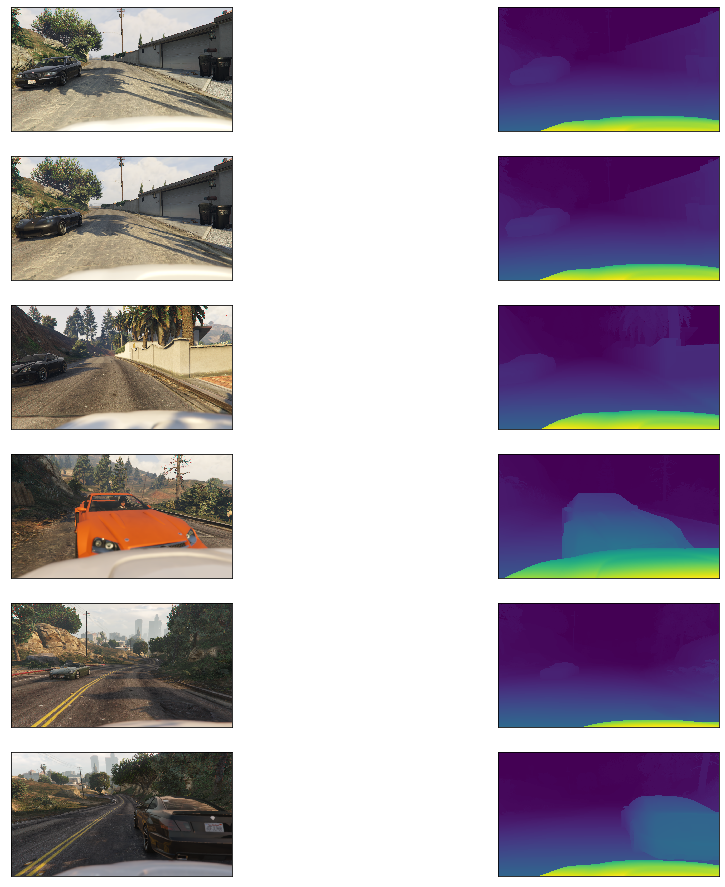

In [292]:
show_list_of_images([x for y in zip(colour_images, depth_images) for x in y], 6, 2)

### Get the feature values of each patch

In [293]:
features_6x6 = [process_patches(image, (6,6), function=create_feature_vector)
                for image in colour_images]

### Mean the depth values accross each patch

In [300]:
depths_6x6 = [process_patches(image,(6,6),function=np.mean)
              for image in depth_images]

### Set an estimate for $\theta$: 
required as otherwise scipy will assume it is a scalar

In [304]:
𝜃 = [1 for i in range(features_6x6[0].shape[-1])]

### Train accross each of first five images

In [310]:
from tqdm.notebook import tqdm

for feature, depth in tqdm(zip(features_6x6[:-1], depths_6x6[:-1]),
                           total=len(features_6x6[:-1]), leave=False):
    𝜃,_ = least_squares(feature,  depth, 𝜃)

### Predict the depth for the final image

In [311]:
predicted_depth = features_6x6[-1] @ 𝜃

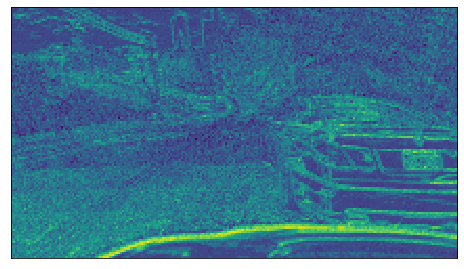

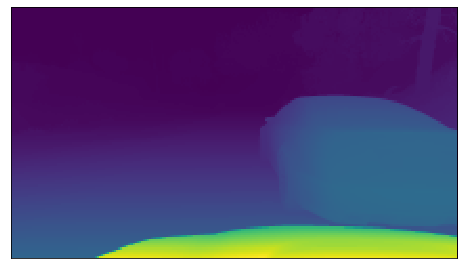

In [312]:
show_img(predicted_depth)
show_img(depths_6x6[-1])